# Chapter 4 - Classification

- [Load *Default* dataset](#Load-Default-dataset)
- [Figure 4.1: *Default* data set](#Figure-4.1:-Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
  - [Figure 4.2: Balance - Default, Estimated Probability](#Figure-4.2:-Balance---Default,-Estimated-Probability)
  - [Table 4.1: Balance - Default, Estimated Coefficients](#Table-4.1:-Balance---Default,-Estimated-Coefficients)
  - [Table 4.2: Student - Default, Estimated Coefficients](#Table-4.2:-Student---Default,-Estimated-Coefficients)
  - [Table 4.3: Balance, Income, Student - Default, Multiple Logistic Regression](#Table-4.3:-Balance,-Income,-Student---Default,-Multiple-Logistic-Regression)
  - [Figure 4.3: Confounding in the *Default* data](#Figure-4.3:-Confounding-in-the-Default-data)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
  - [Table 4.4: A Confusion Matrix (Decision Probability = 50%)](#Table-4.4:-A-Confusion-Matrix-(Decision-Probability-=-50%))
  - [Table 4.5: A Confusion Matrix (Decision Probability = 20%)](#Table-4.5:-A-Confusion-Matrix-(Decision-Probability-=-20%))
  - [Figure 4.7: Threshold - Error Rate](#Figure-4.7:-Threshold---Error-Rate)
  - [Figure 4.8: A ROC curve](#Figure-4.8:-A-ROC-curve)
  - [+ Dimensionality Reduction with LDA](#+-Dimensionality-Reduction-with-LDA)
- [4.6 Lab: Logistic Regression, LDA, QDA, and KNN](#4.6-Lab:-Logistic-Regression,-LDA,-QDA,-and-KNN)
  - [4.6.1 The Stock Market Data](#4.6.1-The-Stock-Market-Data)
  - [4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
  - [4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
  - [4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
  - [+ Naive Bayes Classifier](#+-Naive-Bayes-Classifier)
  - [4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, neighbors
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

%matplotlib inline
plt.style.use('seaborn-white')

warnings.filterwarnings('ignore')

### Visualize
[Plot a confusion matrix (there are lots of plotting codes)](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# Ref https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(y_true, y_pred,
                          target_names=None, title='Confusion matrix', cmap=plt.get_cmap('Blues'), normalize=False, figsize=(8,6)):
    '''
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    '''
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

---
### Load *Default* dataset

In [3]:
df = pd.read_excel('Data/Default.xlsx')
df.head(3)

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947


In [4]:
# factorize() returns two objects: a label array and an array with the unique values
df['default'] = df.default.factorize()[0]
df['student'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947


---
###  Figure 4.1: *Default* data set

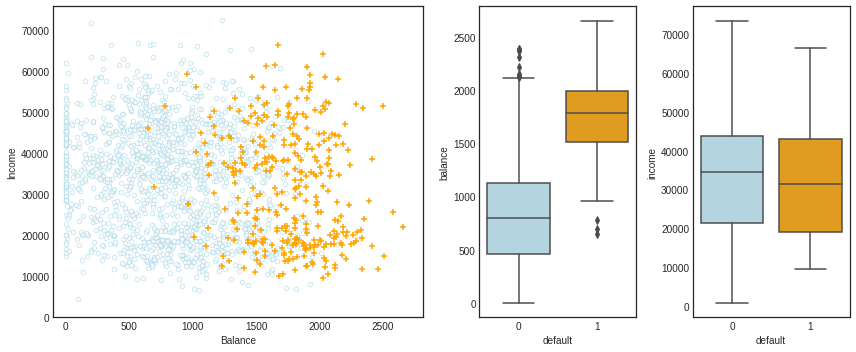

In [5]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default == 1]

ax1.scatter(df_no.balance, df_no.income, s=20, edgecolors='lightblue', facecolors='white',
            marker='o', linewidths=1, alpha=.6)
ax1.scatter(df_yes.balance, df_yes.income, s=40, c='orange',
            marker='+', linewidths=1)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

---
## 4.3 Logistic Regression
### Figure 4.2: Balance - Default, Estimated Probability

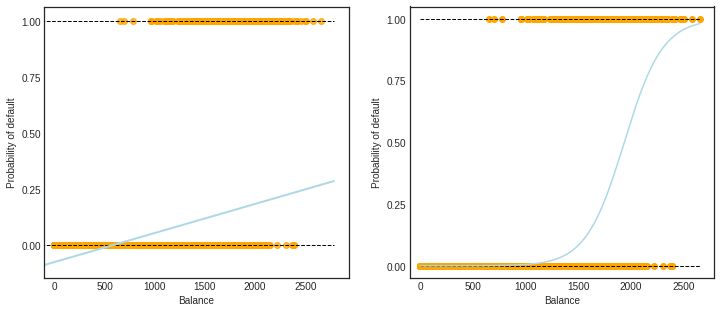

In [6]:
X_train = df.balance.values.reshape(-1,1)
y_train = df.default

# Create array of test data
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

# Calculate the classification probability
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(df.balance, df.default, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y_train, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

---
### Table 4.1: Balance - Default, Estimated Coefficients

##### Using  scikit-learn

In [7]:
X_train = df.balance.values.reshape(-1,1)
y_train = df.default

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)

print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132784]


##### Using statsmodels

In [8]:
X_train = sm.add_constant(df.balance)
y_train = df.default.ravel()

est = Logit(y_train, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


---
###  Table 4.2: Student - Default, Estimated Coefficients

In [9]:
X_train = sm.add_constant(df.student)
y_train = df.default.ravel()

est = Logit(y_train, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


---
###  Table 4.3: Balance, Income, Student - Default, Multiple Logistic Regression

In [10]:
X_train = sm.add_constant(df[['balance', 'income', 'student']])
y_train = df.default.ravel()

est = Logit(y_train, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


---
### Figure 4.3: Confounding in the *Default* data

In [11]:
# balance and default vectors for students
X_student = df[df.student == 1].balance.values.reshape(-1,1) 
y_student = df[df.student == 1].default

# balance and default vectors for non-students
X_not_student = df[df.student == 0].balance.values.reshape(-1,1) 
y_not_student = df[df.student == 0].default

clf_student = skl_lm.LogisticRegression(solver='newton-cg')
clf_not_student = skl_lm.LogisticRegression(solver='newton-cg')

clf_student.fit(X_student, y_student)
clf_not_student.fit(X_not_student, y_not_student)

# Test data for ploting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

prob_student = clf_student.predict_proba(X_test)
prob_not_student = clf_not_student.predict_proba(X_test)

In [12]:
df.groupby(['student','default']).size().unstack('default')

default,0,1
student,,
0,6850,206
1,2817,127


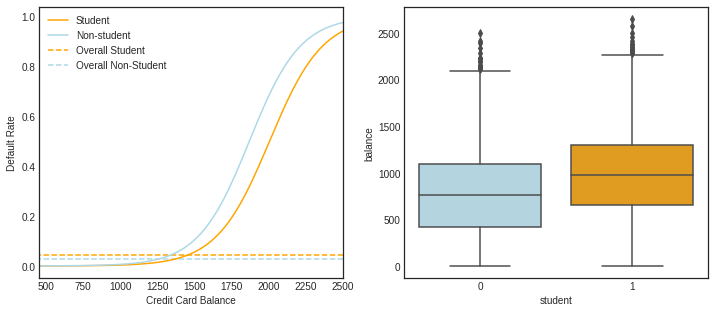

In [13]:
# Creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob_student)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob_not_student)[1], color='lightblue', label='Non-student')
ax1.hlines(df[df.default == 1][df.student == 1].shape[0]/df[df.student == 1].shape[0],
           colors='orange',
           label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(df[df.default == 1][df.student == 0].shape[0]/df[df.student == 0].shape[0],
           colors='lightblue',
           label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc='upper left')

# Right plot
c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

---
## 4.4 Linear Discriminant Analysis
### Table 4.4: A Confusion Matrix (Decision Probability = 50%)

In [14]:
X = df[['balance', 'income', 'student']].as_matrix()
y_true = df.default.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y_true).predict(X)

df_ = pd.DataFrame({'True default status': y_true,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [15]:
print(classification_report(y_true, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



---
### Table 4.5: A Confusion Matrix (Decision Probability = 20%)
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [16]:
decision_prob = 0.2
y_prob = lda.fit(X, y_true).predict_proba(X)

df_ = pd.DataFrame({'True default status': y_true,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9435,140
Yes,232,193


---
### Figure 4.7: Threshold - Error Rate

In [17]:
thresholds = np.arange(0, 0.52, 0.01)
FN_rates = []
FP_rates = []
error_rates = []

for threshold in thresholds:
    y_pred = y_prob[:, 1] > threshold
    FN_rate = np.sum(np.logical_and(y_pred == 0, y_true == 1)) / np.sum(y_true == 1)
    FP_rate = np.sum(np.logical_and(y_pred == 1, y_true == 0)) / np.sum(y_true == 0)
    error_rate = np.sum(y_pred != y_true) / y_pred.size
    
    FN_rates.append(FN_rate)
    FP_rates.append(FP_rate)
    error_rates.append(error_rate)

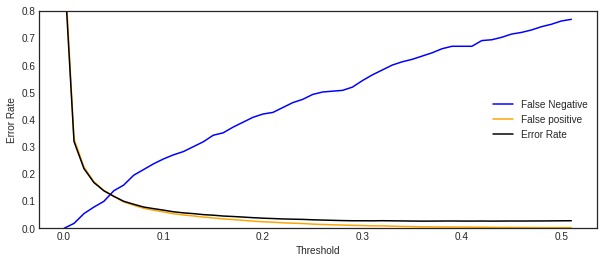

In [18]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.ylim(0, 0.8)
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.plot(thresholds, FN_rates, color='blue', label='False Negative')
plt.plot(thresholds, FP_rates, color='orange', label='False positive')
plt.plot(thresholds, error_rates, color='black', label='Error Rate')
plt.legend()
plt.show()

---
### Figure 4.8: A ROC curve

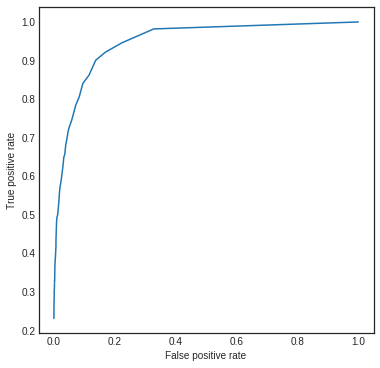

In [19]:
TP_rates = [1 - FN_rate for FN_rate in FN_rates]

plt.rcParams['figure.figsize'] = (6, 6)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(FP_rates, TP_rates)
plt.show()

---
### Using Scikit Learn

In [20]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])

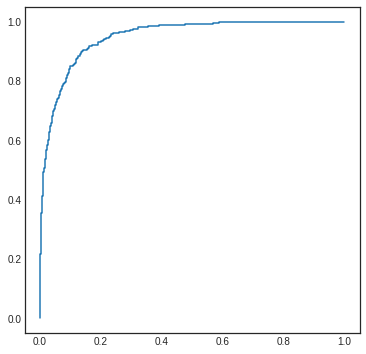

In [21]:
plt.plot(fpr, tpr)
plt.show()

In [22]:
auc_score = auc(fpr, tpr)
print(auc_score)

0.9495202246831501


In [23]:
auc_score = roc_auc_score(y_true, y_prob[:, 1])
print(auc_score)

0.9495202246831501


---
### + Dimensionality Reduction with LDA

<img src="lda.png" style="width: 75%;"/>

In [24]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

print(X.shape, y.shape, target_names)

(150, 4) (150,) ['setosa' 'versicolor' 'virginica']


In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X, y).transform(X)

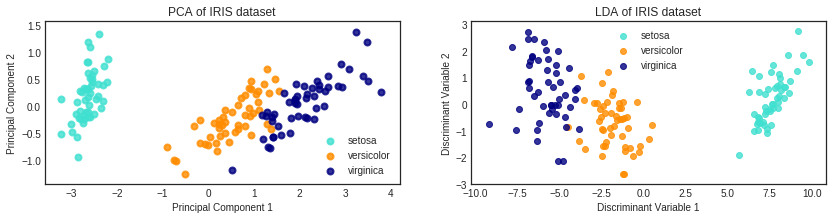

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,3))
colors = ['turquoise', 'darkorange', 'navy']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    PC1 = X_pca[y == i, 0]
    PC2 = X_pca[y == i, 1]
    ax1.scatter(PC1, PC2, color=color, alpha=0.8, lw=lw,
                label=target_name)
ax1.legend(loc='best', shadow=False, scatterpoints=1)
ax1.set_title('PCA of IRIS dataset')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    DV1 = X_lda[y == i, 0]
    DV2 = X_lda[y == i, 1]
    ax2.scatter(DV1, DV2, alpha=0.8, color=color,
                label=target_name)
ax2.legend(loc='best', shadow=False, scatterpoints=1)
ax2.set_title('LDA of IRIS dataset')
ax2.set_xlabel('Discriminant Variable 1')
ax2.set_ylabel('Discriminant Variable 2')

plt.show()

---
## 4.6 Lab: Logistic Regression, LDA, QDA, and KNN

### 4.6.1 The Stock Market Data

In [27]:
df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df.head(3)

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down


---
### 4.6.3 Linear Discriminant Analysis

In [28]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
y_pred = lda.fit(X_train, y_train).predict(X_test)

In [29]:
lda.priors_

array([0.49198397, 0.50801603])

In [30]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [31]:
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [32]:
print(confusion_matrix(y_test, y_pred))

[[ 35  76]
 [ 35 106]]


In [33]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [34]:
y_prob = lda.predict_proba(X_test)

In [35]:
Counter(y_prob[:,1] > 0.5)

Counter({False: 70, True: 182})

In [36]:
Counter(y_prob[:,1] > 0.9)

Counter({False: 252})

---
### 4.6.4 Quadratic Discriminant Analysis

In [37]:
qda = QuadraticDiscriminantAnalysis()
y_pred = qda.fit(X_train, y_train).predict(X_test)

In [38]:
qda.priors_

array([0.49198397, 0.50801603])

In [39]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [40]:
print(confusion_matrix(y_test, y_pred))

[[ 30  81]
 [ 20 121]]


In [41]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



---
### 4.6.5 K-Nearest Neighbors

In [42]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
y_pred = knn.fit(X_train, y_train).predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[43 68]
 [58 83]]
              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



In [43]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
y_pred = knn.fit(X_train, y_train).predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[48 63]
 [55 86]]
              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



### + Naive Bayes Classifier

In [44]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [45]:
y_pred = clf.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=clf.classes_,
                     columns=clf.classes_)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)
print(classification_report(y_test, y_pred))

Predicted  Down   Up
True                
Down         29   82
Up           20  121
              precision    recall  f1-score   support

        Down       0.59      0.26      0.36       111
          Up       0.60      0.86      0.70       141

    accuracy                           0.60       252
   macro avg       0.59      0.56      0.53       252
weighted avg       0.59      0.60      0.55       252



---
### 4.6.6 An Application to Caravan Insurance Data

#### K-Nearest Neighbors

In [46]:
df = pd.read_csv('Data/Caravan.csv')
df.head(3)

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No
2,3,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,No


In [47]:
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return y_pred, score, clf.classes_

              precision    recall  f1-score   support

          No       0.94      0.94      0.94      2737
         Yes       0.08      0.07      0.08       174

    accuracy                           0.89      2911
   macro avg       0.51      0.51      0.51      2911
weighted avg       0.89      0.89      0.89      2911



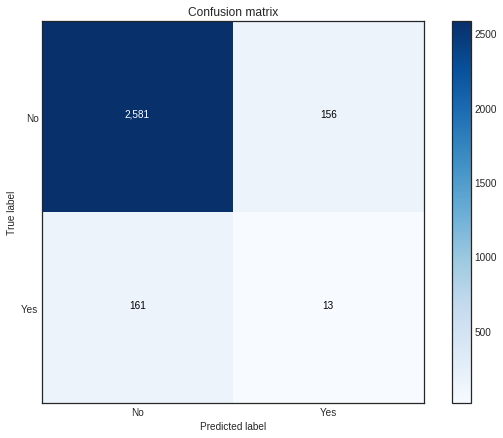

              precision    recall  f1-score   support

          No       0.94      0.98      0.96      2737
         Yes       0.10      0.03      0.05       174

    accuracy                           0.93      2911
   macro avg       0.52      0.51      0.50      2911
weighted avg       0.89      0.93      0.91      2911



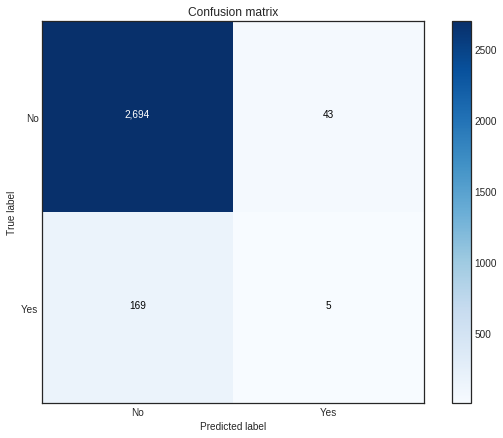

              precision    recall  f1-score   support

          No       0.94      0.99      0.97      2737
         Yes       0.09      0.01      0.02       174

    accuracy                           0.93      2911
   macro avg       0.52      0.50      0.49      2911
weighted avg       0.89      0.93      0.91      2911



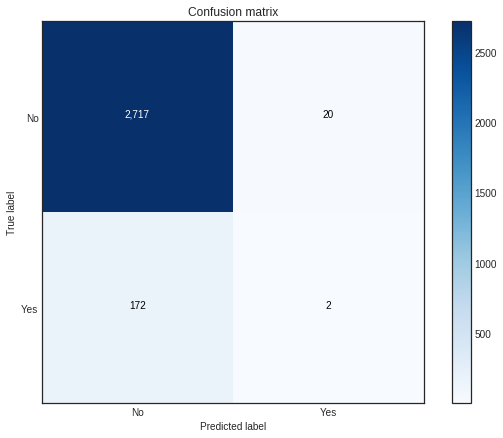

In [50]:
for i in [1,3,5]:
    y_pred, score, classes = KNN(i)
    print(classification_report(y_test, y_pred, target_names=classes))
    plot_confusion_matrix(y_test, y_pred, target_names=classes)

####  Logistic Regression

In [51]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

          No       0.94      1.00      0.97      2737
         Yes       0.23      0.02      0.03       174

    accuracy                           0.94      2911
   macro avg       0.59      0.51      0.50      2911
weighted avg       0.90      0.94      0.91      2911



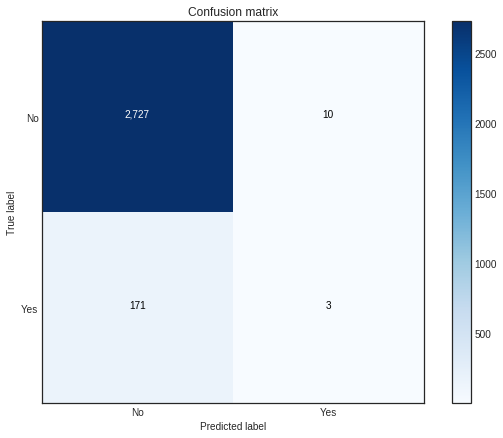

In [52]:
y_pred = regr.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, target_names=regr.classes_)

              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2737
        True       0.17      0.11      0.14       174

    accuracy                           0.91      2911
   macro avg       0.56      0.54      0.55      2911
weighted avg       0.90      0.91      0.91      2911



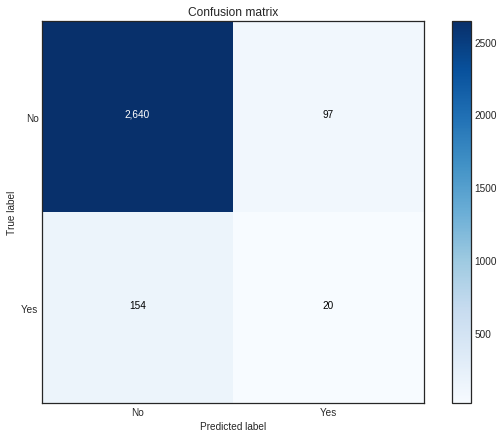

In [53]:
decision_prob = 0.2
y_prob = regr.predict_proba(X_test)
y_pred = y_prob[:, 1] > decision_prob
y_true = y_test == 'Yes'

print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, target_names=regr.classes_)